## Run this notebook to get Clone Hero importable output from validation set

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os

DRIVE_PATH = '/content/gdrive/My\ Drive/tensor_hero'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
assert os.path.exists(DRIVE_PYTHON_PATH)

SYM_PATH = '/content/final_project'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

In [ ]:
import sys
from pathlib import Path
base = Path('/content/drive/My\ Drive/tensor_hero/tensor-hero')
sys.path.append(str(base))
%cd $SYM_PATH/'tensor-hero'

/content/gdrive/My Drive/tensor_hero/tensor-hero


In [ ]:
# Find the training data
cwd = os.getcwd()
print('Current Working Directory: \n{}\n'.format(cwd))

train_path = Path(cwd) / 'fully_curated_colab' / 'train'
val_path = Path(cwd) / 'fully_curated_colab' / 'val'
print('Training Path: \n{}\n'.format(train_path))
print('Validation Path: \n{}\n'.format(val_path))

!ls

Current Working Directory: 
/content/gdrive/My Drive/tensor_hero/tensor-hero

Training Path: 
/content/gdrive/My Drive/tensor_hero/tensor-hero/fully_curated_colab/train

Validation Path: 
/content/gdrive/My Drive/tensor_hero/tensor-hero/fully_curated_colab/val

'CH separated'		  guitar_hero_curated	 runs
 colab_ogg_key_dict.pkl   inference		 separated_colab
'Data Exploration'	  initialization.ipynb	 tensorboard.ipynb
 data_preprocessing	  LICENSE		 tensor_hero
 Documentation		  logs			 tensor_hero_backup
 example_song		  model			 test_key.pkl
 Experiments		  output.png		 Training_Data
 full_curated		  Prototyping		 train_key.pkl
 fully_curated_colab	  README.md		 val_key.pkl
'GH separated'		  requirements.txt


## Check to see what GPU is being utilized

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Apr 23 20:48:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

device: cuda
Loading model weights

Predicting Judas Priest - 13 Lone Wolf [XEntombmentX, Aren Eternal]

Loading song...


  9%|▉         | 7/78 [00:00<00:01, 63.70it/s]

computing onsets...


  0%|          | 0/78 [00:00<?, ?it/s]

predicting notes...


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


onset f1: 0.61


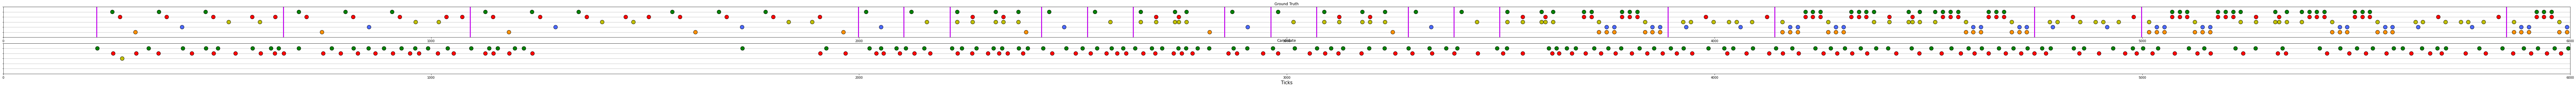

In [3]:
import sys
import pathlib
from pathlib import Path
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath
sys.path.insert(1, str(Path.cwd().parent))
from tensor_hero.inference import full_song_prediction_onset
from tensor_hero.model import OnsetTransformer
from tensor_hero.visualization import plot_chart, slice_notes
from tensor_hero.preprocessing.chart import chart2tensor
from tensor_hero.preprocessing.data import __remove_modifiers, __remove_release_keys
from tensor_hero.onset import notes_array_onset_f1
import torch
import pickle

MODEL_NAME = 'o4'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

# Load params
params = Path.cwd() / 'saved_models' / MODEL_NAME / 'params.pkl'
# params = Path.cwd() / 'model' / 'saved_models' / MODEL_NAME / 'params.pkl'
with open (params, 'rb') as f:
  params = pickle.load(f)

# Define model
model = OnsetTransformer(
    embedding_size = params['embedding_size'],
    trg_vocab_size = params['trg_vocab_size'],
    num_heads = params['num_heads'],
    num_encoder_layers = params['num_encoder_layers'],
    num_decoder_layers = params['num_decoder_layers'],
    forward_expansion = params['embedding_size']*params['forward_expansion'],
    dropout = params['dropout'],
    max_len = params['max_src_len'],
    device = device
).to(device)

# Load weights into model
print('Loading model weights')
# model_weights = Path.cwd() / 'model' / 'saved_models' / MODEL_NAME / (MODEL_NAME + '.pt')
model_weights = Path.cwd() / 'saved_models' / MODEL_NAME / (MODEL_NAME + '.pt')
model.load_state_dict(torch.load(str(model_weights)))

# Get list of validation songs
# val_dir = Path.cwd() / 'model' / 'validation_output' / 'raw_val'
val_dir = Path.cwd() / 'validation_output' / 'raw_val'
raw_paths = [val_dir / x for x in os.listdir(val_dir)]

# Create folder to hold output
if not os.path.exists(val_dir.parent / 'model_output' / MODEL_NAME):
  os.mkdir(val_dir.parent / 'model_output' / MODEL_NAME)

# Loop through validation songs, getting model output and plots along the way
for song_dir in raw_paths:
  if 'Judas Priest' not in song_dir.parts[-1]:
    continue
  print(f'\nPredicting {song_dir.parts[-1]}\n')
  # Create song metadata and define outfolder
  song_name = 'TH model ' + MODEL_NAME + ': ' + song_dir.parts[-1]
  song_metadata = {'Name' : song_name,
                'Artist' : 'TH_'+MODEL_NAME,
                'Charter' : 'tensorhero',
                'Offset' : 0,
                'Resolution' : 192,
                'Genre' : 'electronic',
                'MediaType' : 'cd',
                'MusicStream' : 'other.wav'}
  outfolder = val_dir.parent / 'model_output' / MODEL_NAME / song_dir.parts[-1]

  # Predict song
  predicted_notes_array = full_song_prediction_onset(song_path=song_dir / 'other.wav',
                                                     model=model,
                                                     device=device,
                                                     sos_idx=0,
                                                     eos_idx=1,
                                                     max_src_len=params['max_src_len'],
                                                     max_trg_len=params['max_trg_len'],
                                                     song_metadata=song_metadata,
                                                     outfolder=outfolder,
                                                     onset_params=[2, 3, 7, 1, 5, 0.1],
                                                     odf='d_energy_mult_energy',
                                                     hop_len=441,
                                                     p=0.2,
                                                     gamma=0.94,
                                                     PRINT=False)
  
  # Print first 60 seconds of output compared to ground truth
  gt_notes_array = chart2tensor(song_dir / 'notes.chart')  # convert from chart to simplified notes array
  gt_notes_array = __remove_release_keys(gt_notes_array)
  gt_notes_array = __remove_modifiers(gt_notes_array)
  
  print(f'onset f1: {notes_array_onset_f1(gt_notes_array, predicted_notes_array):.2f}')
  _ = plot_chart(ground_truth=gt_notes_array[:6000], candidate=predicted_notes_array[:6000])
